In [580]:
%matplotlib inline

import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal, stats
import seaborn as sns

from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools import eval_measures
import statsmodels.regression
import statsmodels.tools
import warnings
warnings.filterwarnings('ignore')


## some datetime conversion warning
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Always make it pretty.
plt.style.use('ggplot')



In [581]:
#read in CDC data from clinical labs
clinical_lab_df = pd.read_csv("/Users/GuntherUlvanget/Capstone/Capstone2/Influenza/stateFluViewPhase2Data 2/WHO_NREVSS_Clinical_Labs.csv",header = 1, na_values = 'X', na_filter = True)

#not all states report weekly public health data. convert the X to na and drop

clinical_lab_df.dropna(axis = 0, inplace = True)
clinical_lab_df.head()
#Create a date row from the year and week columns
clinical_lab_df["date"] = pd.to_datetime(clinical_lab_df.YEAR.astype(str), format='%Y') + \
             pd.to_timedelta(clinical_lab_df.WEEK.mul(7).astype(str) + ' days')

#clinical_lab_df.drop(columns = ["REGION TYPE","YEAR","WEEK", "PERCENT POSITIVE", "PERCENT A","PERCENT B"], inplace = True)





#read in the CDC file on combined clinical and public health labs pre 2015, post 2015 the data was split between the types of labs.
#public health labs only report full season data, not weekly, they will not be used.
#not all states report weekly public health data. convert the X to na and drop
combined_labs_pre_2015_df = pd.read_csv("/Users/GuntherUlvanget/Capstone/Capstone2/Influenza/stateFluViewPhase2Data 2/WHO_NREVSS_Combined_prior_to_2015_16.csv",  header = 1, na_values = 'X', na_filter = True)

combined_labs_pre_2015_df.dropna(axis = 0, inplace = True)

#for years 2015-2020, Influenza strains were reported but not the total A and Total B strains. 
#columns were created to 
combined_labs_pre_2015_df["TOTAL A"]= pd.to_numeric(combined_labs_pre_2015_df["A (2009 H1N1)"]) + pd.to_numeric(combined_labs_pre_2015_df["A (H3)"]) + pd.to_numeric(combined_labs_pre_2015_df["A (Subtyping not Performed)"]) + pd.to_numeric(combined_labs_pre_2015_df["A (Unable to Subtype)"])+ pd.to_numeric(combined_labs_pre_2015_df ["A (H1)"]) 

combined_labs_pre_2015_df["TOTAL B"]= pd.to_numeric(combined_labs_pre_2015_df["H3N2v"]) +  pd.to_numeric(combined_labs_pre_2015_df["B"])


#Create a date row from the year and week columns
combined_labs_pre_2015_df["date"] =  pd.to_datetime(combined_labs_pre_2015_df.YEAR.astype(str), format='%Y') + \
             pd.to_timedelta(combined_labs_pre_2015_df.WEEK.mul(7).astype(str) + ' days')

##combined_labs_pre_2015_df.drop(columns= ["REGION TYPE","A (2009 H1N1)", "A (H3)" ,"H3N2v",  "B","A (Subtyping not Performed)","YEAR","WEEK", "PERCENT POSITIVE", "A (H1)",  "A (Unable to Subtype)"], inplace = True)
combined_labs_pre_2015_df.head()

,REGION TYPE,REGION,YEAR,WEEK,TOTAL SPECIMENS,PERCENT POSITIVE,A (2009 H1N1),A (H1),A (H3),A (Subtyping not Performed),A (Unable to Subtype),B,H3N2v,TOTAL A,TOTAL B,date
0,States,Alabama,2010,40,54.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010-10-08
1,States,Alaska,2010,40,40.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010-10-08
2,States,Arizona,2010,40,40.0,2.50,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2010-10-08
3,States,Arkansas,2010,40,15.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010-10-08
4,States,California,2010,40,183.0,3.28,2.0,0.0,3.0,0.0,0.0,1.0,0.0,5.0,1.0,2010-10-08


In [582]:
#Join the two differeing reports
ten_year_influenza_confirmed = pd.concat([combined_labs_pre_2015_df,clinical_lab_df], sort=False)

In [583]:
#created a column of total labratory confirmed cases.
ten_year_influenza_confirmed['Confirmed_Infections'] = ten_year_influenza_confirmed["TOTAL A"] + ten_year_influenza_confirmed["TOTAL B"]

number_colors=len(ten_year_influenza_confirmed.REGION.unique())


In [584]:


total_infections =ten_year_influenza_confirmed.groupby(["date"]).sum()
mean_total_infections = ten_year_influenza_confirmed.groupby(["date"]).mean()

total_infections.reset_index(inplace=True)
mean_total_infections.reset_index(inplace = True)


#what is the mean number of confirmed infections for each state
state_mean_total_infections = ten_year_influenza_confirmed.groupby(["REGION"]).mean()
state_mean_total_infections.head()

,YEAR,WEEK,TOTAL SPECIMENS,PERCENT POSITIVE,A (2009 H1N1),A (H1),A (H3),A (Subtyping not Performed),A (Unable to Subtype),B,H3N2v,TOTAL A,TOTAL B,PERCENT A,PERCENT B,Confirmed_Infections
REGION,,,,,,,,,,,,,,,,
Alabama,2014.945378,26.768908,281.920168,7.273592,1.075697,0.0,3.860558,3.231076,0.0,3.127490,0.0,22.273109,9.315126,4.001200,2.215822,31.588235
Alaska,2013.495114,26.270358,64.729642,17.029479,3.868726,0.0,10.092664,0.393822,0.0,3.042471,0.0,12.439739,2.661238,9.603333,3.607500,15.100977
Arizona,2014.905350,26.878601,160.072016,12.453148,8.842912,0.0,21.091954,0.808429,0.0,6.409962,0.0,22.014403,6.063786,3.416222,1.908578,28.078189
Arkansas,2014.978769,26.743100,94.144374,8.222654,1.198381,0.0,2.279352,3.380567,0.0,2.461538,0.0,12.636943,4.902335,5.171116,2.593571,17.539278
California,2014.905350,26.878601,741.294239,7.148827,6.973180,0.0,29.325670,17.563218,0.0,10.306513,0.0,68.327160,28.057613,4.694089,2.190311,96.384774


In [768]:
# the following states have higher morbidity rates due to influenza than the nations averag of 13.5 per 100,000. We will examin them first
states_of_interest=["Hawaii"," Mississippi", "Tennessee","New York","Nevada","Kentucky","West Virginia","Alabama", "Arkansas"] 


#does any month have zero confirmed cases
ten_year_influenza_confirmed['Confirmed_Infections'].unique()
ten_year_influenza_confirmed.groupby(['Confirmed_Infections']).count().head()



,REGION TYPE,REGION,YEAR,WEEK,TOTAL SPECIMENS,PERCENT POSITIVE,A (2009 H1N1),A (H1),A (H3),A (Subtyping not Performed),A (Unable to Subtype),B,H3N2v,TOTAL A,TOTAL B,date,PERCENT A,PERCENT B
Confirmed_Infections,,,,,,,,,,,,,,,,,,
0.0,5035,5035,5035,5035,5035,5035,2874,2874,2874,2874,2874,2874,2874,5035,5035,5035,2161,2161
1.0,2100,2100,2100,2100,2100,2100,1040,1040,1040,1040,1040,1040,1040,2100,2100,2100,1060,1060
2.0,1233,1233,1233,1233,1233,1233,617,617,617,617,617,617,617,1233,1233,1233,616,616
3.0,882,882,882,882,882,882,458,458,458,458,458,458,458,882,882,882,424,424
4.0,675,675,675,675,675,675,347,347,347,347,347,347,347,675,675,675,328,328


In [586]:
#mask states
group1 = ten_year_influenza_confirmed.REGION.unique()[0:10]
group2 = ten_year_influenza_confirmed.REGION.unique()[10:20]
group3 = ten_year_influenza_confirmed.REGION.unique()[20:30]
group4 = ten_year_influenza_confirmed.REGION.unique()[30:40]
group5 = ten_year_influenza_confirmed.REGION.unique()[40:]
groups= [group1,group2, group3, group4, group5]

In [587]:
#seperate states into subgroups to increase ability to read graphs
group_states = []
for i,j in enumerate(groups):
    mask_list = [ten_year_influenza_confirmed["REGION"] == state for state in j ] 
    state_df= [ten_year_influenza_confirmed[masked] for masked in mask_list]
    group_states.append( pd.concat(state_df))

[None, None, None, None, None]

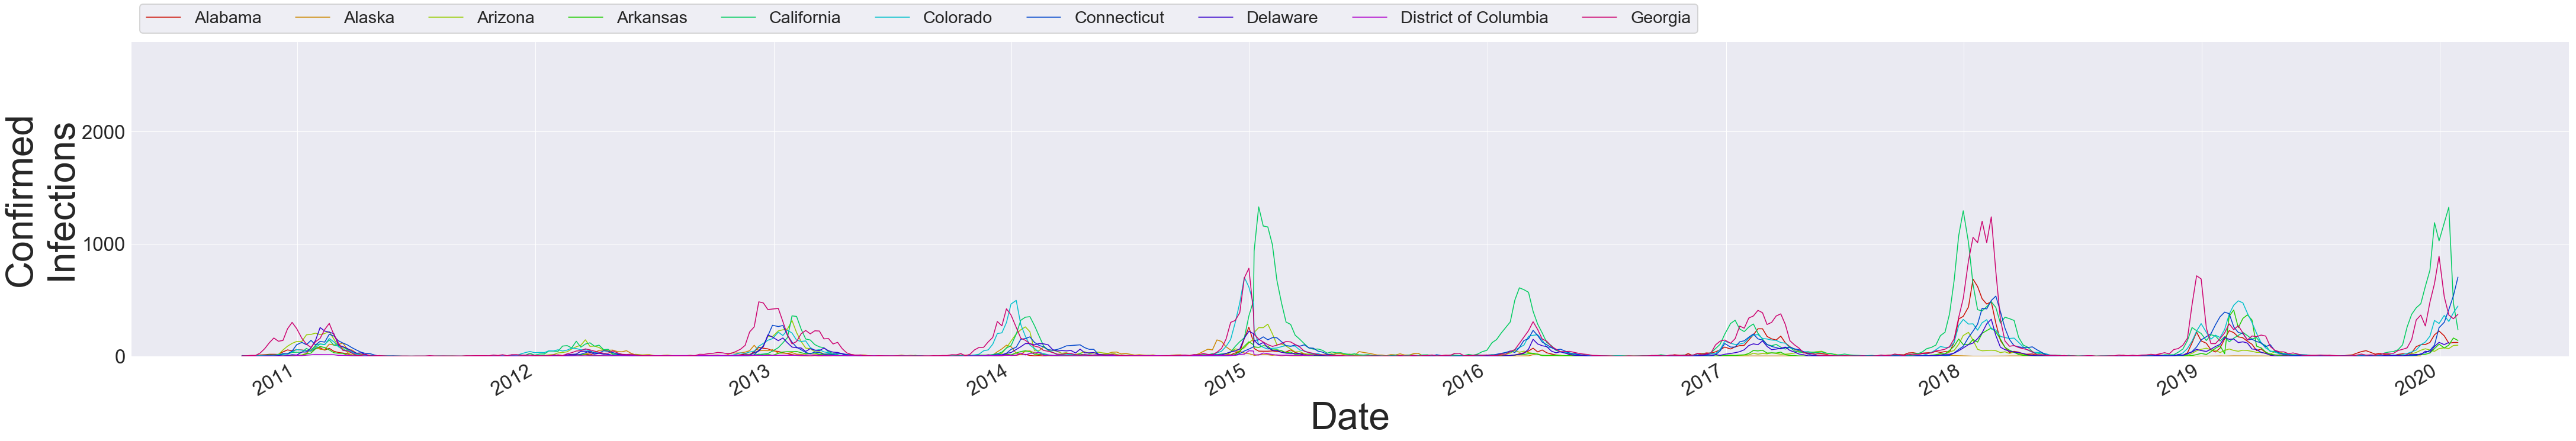

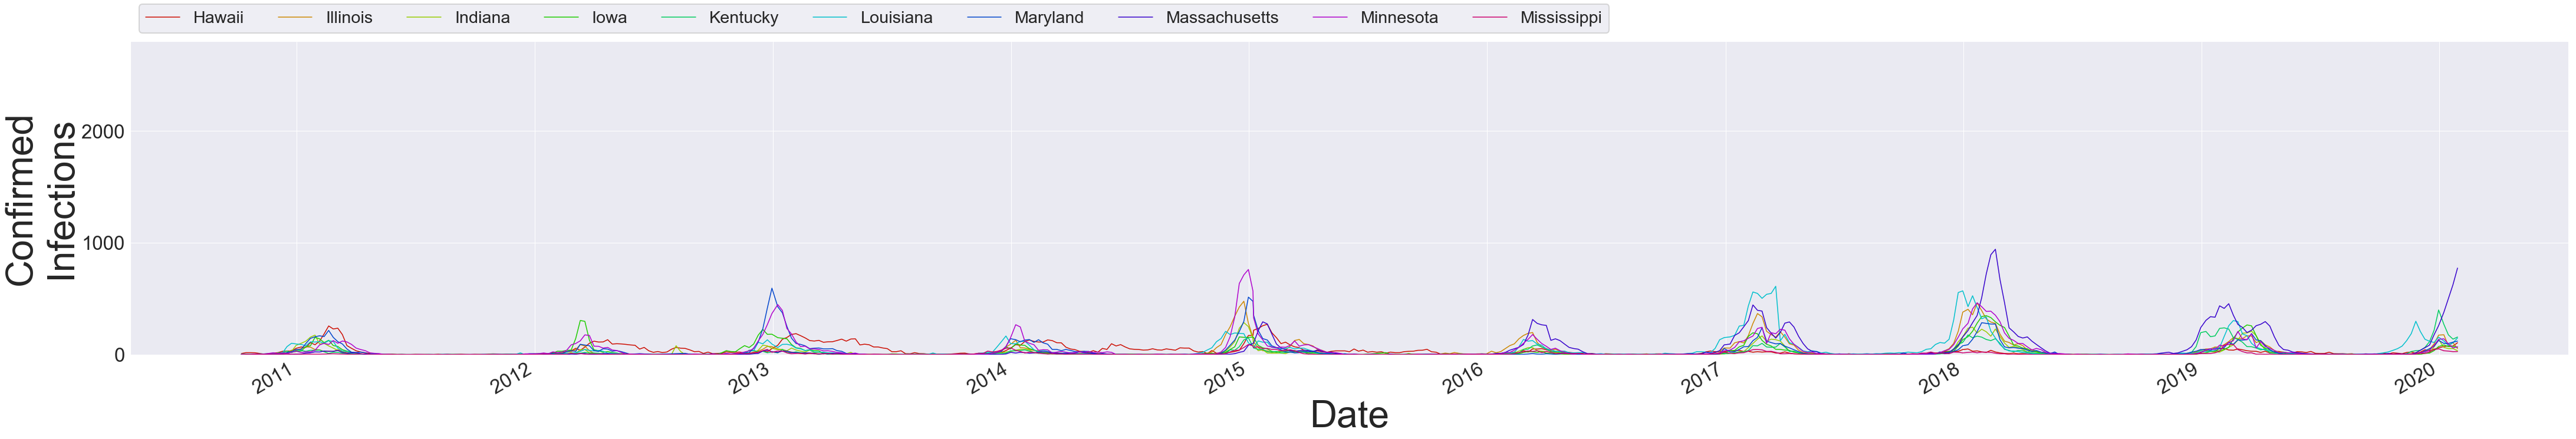

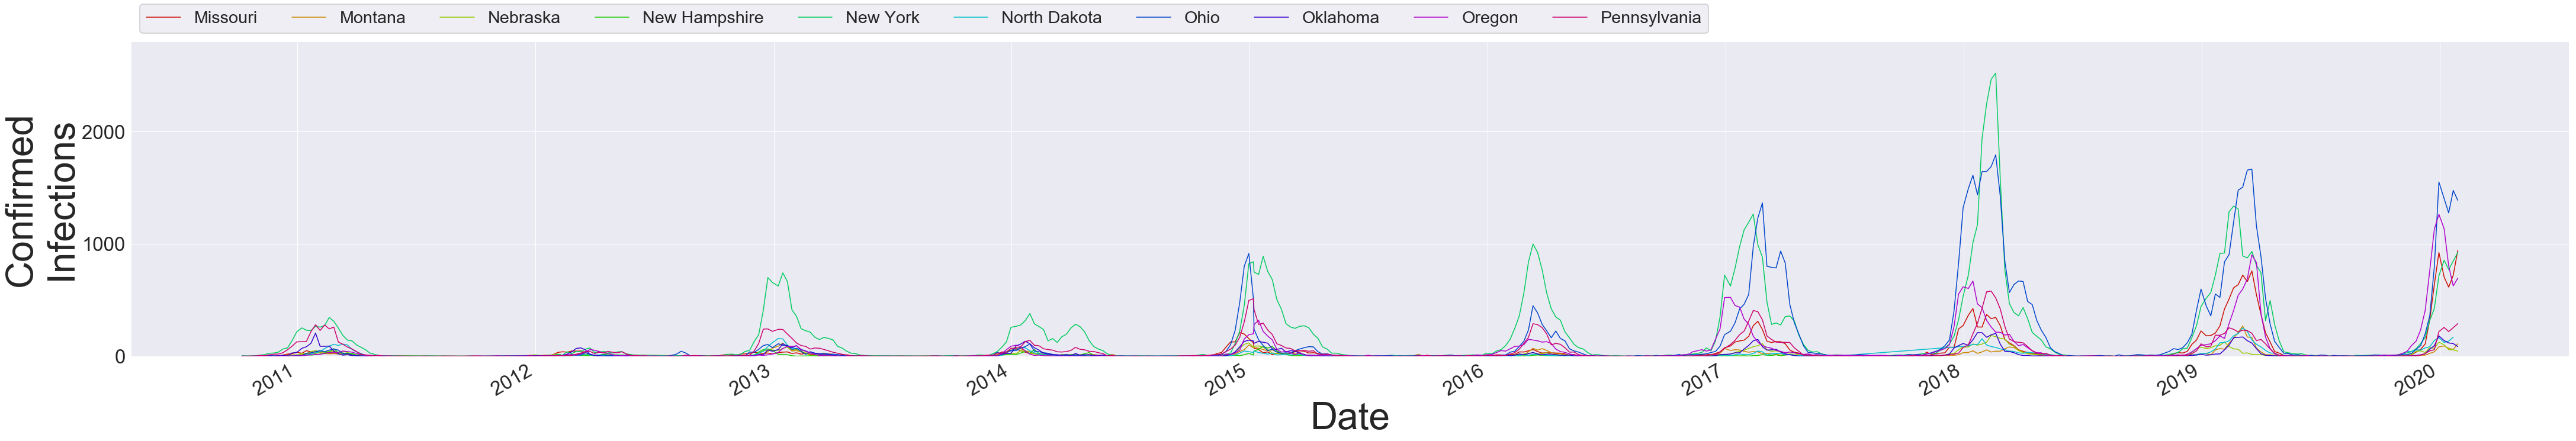

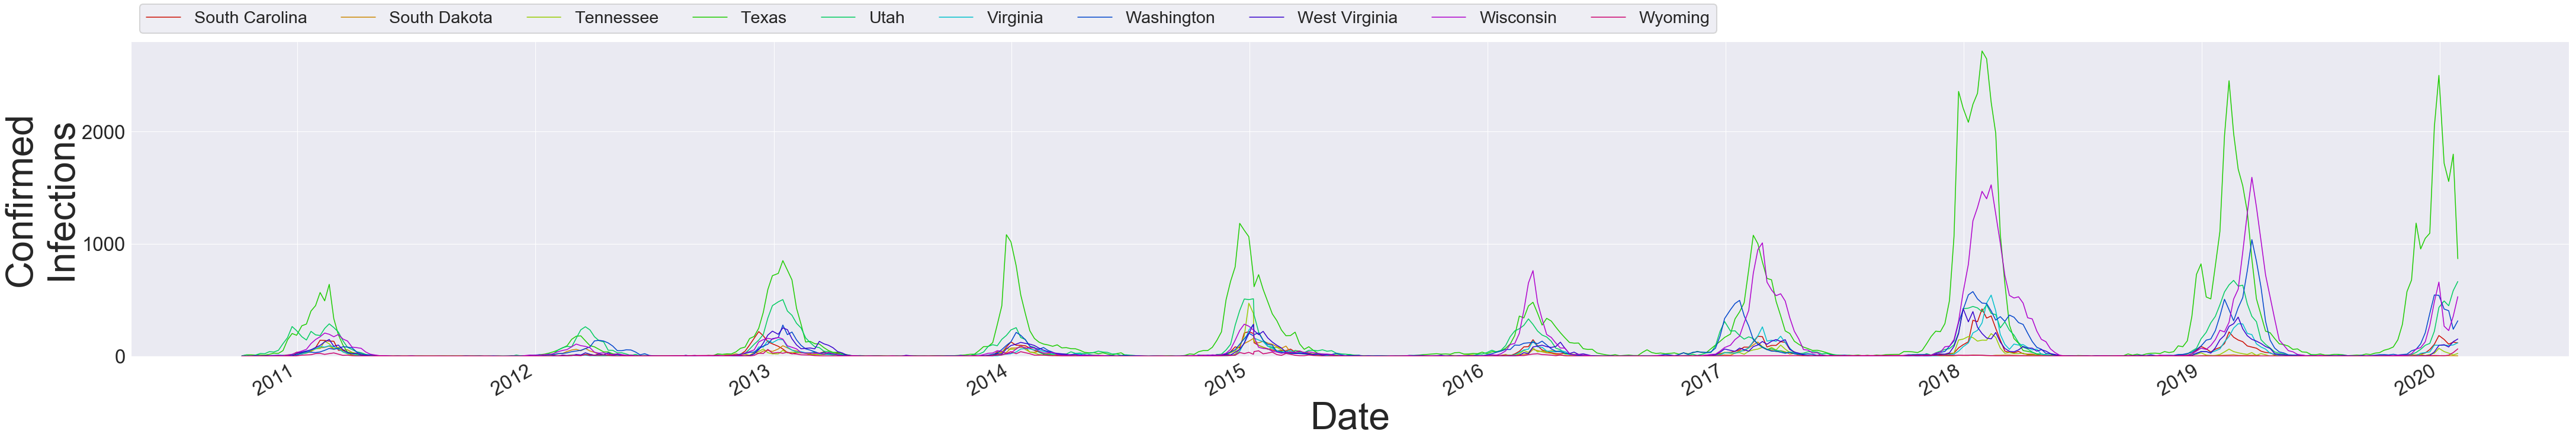

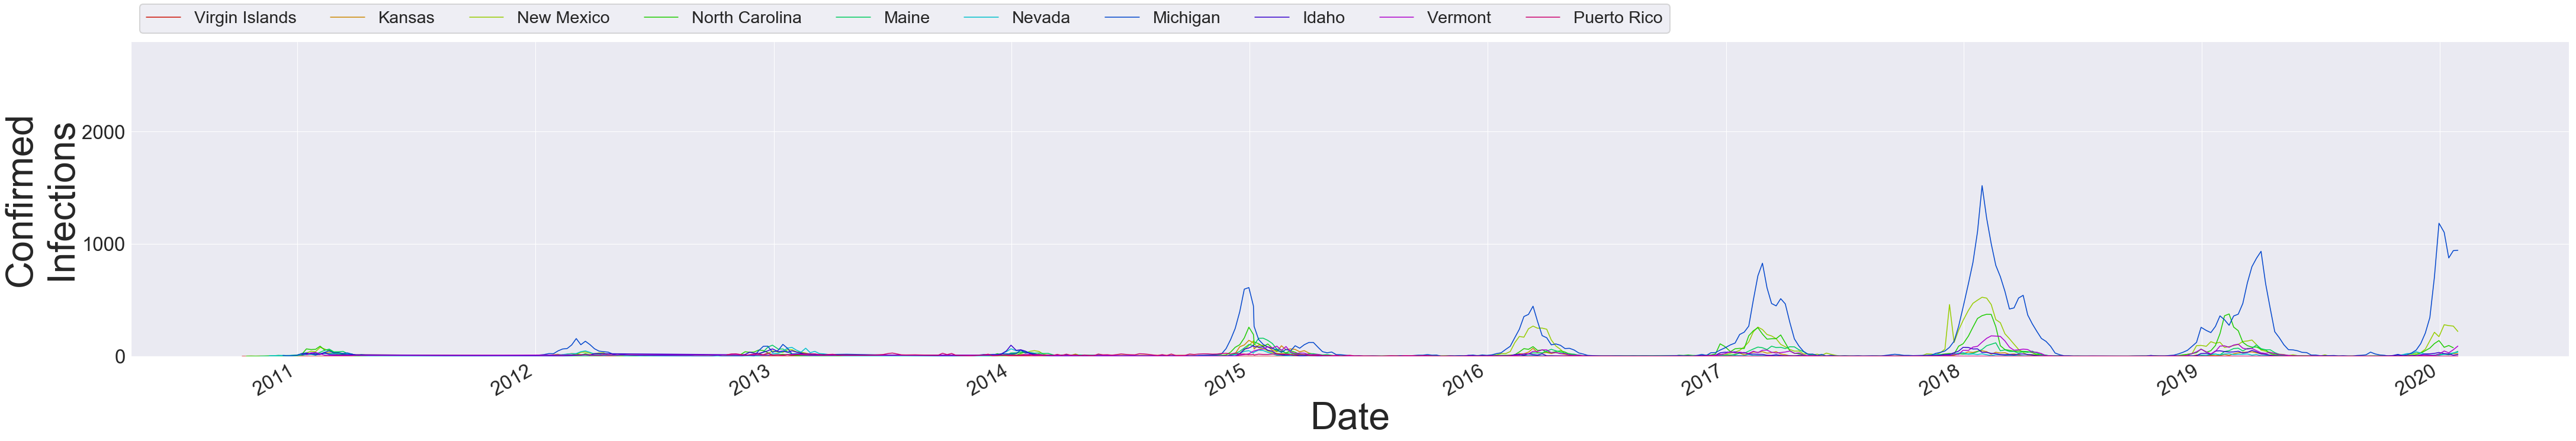

In [588]:
#a function to plot each grouping for EDA
def graph_states(df):
    
    sns.set_context("poster")

   
    number_colors=len(df.REGION.unique())
    labels = df.REGION.unique()
    sns.set(font_scale=3)
    g = sns.relplot(x="date", 
                    y="Confirmed_Infections", 
                    hue ="REGION", kind="line", 
                    data=df, 
                    height=10, 
                    aspect=6,
                    palette=sns.hls_palette(number_colors, l=.4, s=1),
                   legend=False)
    sns.set_context("poster")



    plt.legend(labels, ncol=10, bbox_to_anchor=(0, 1),
                  loc='lower left', fontsize='large')
    g.fig.autofmt_xdate()
    sns.set(font_scale=5)
    plt.ylim(0,2800) 
    plt.ylabel("Confirmed\nInfections", fontsize=64) 
    plt.xlabel("Date", fontsize=64)
    plt.plot()

    plt.savefig(df.REGION.unique()[0], bbox_inches = "tight") 
[graph_states(group) for group in group_states] 




[]

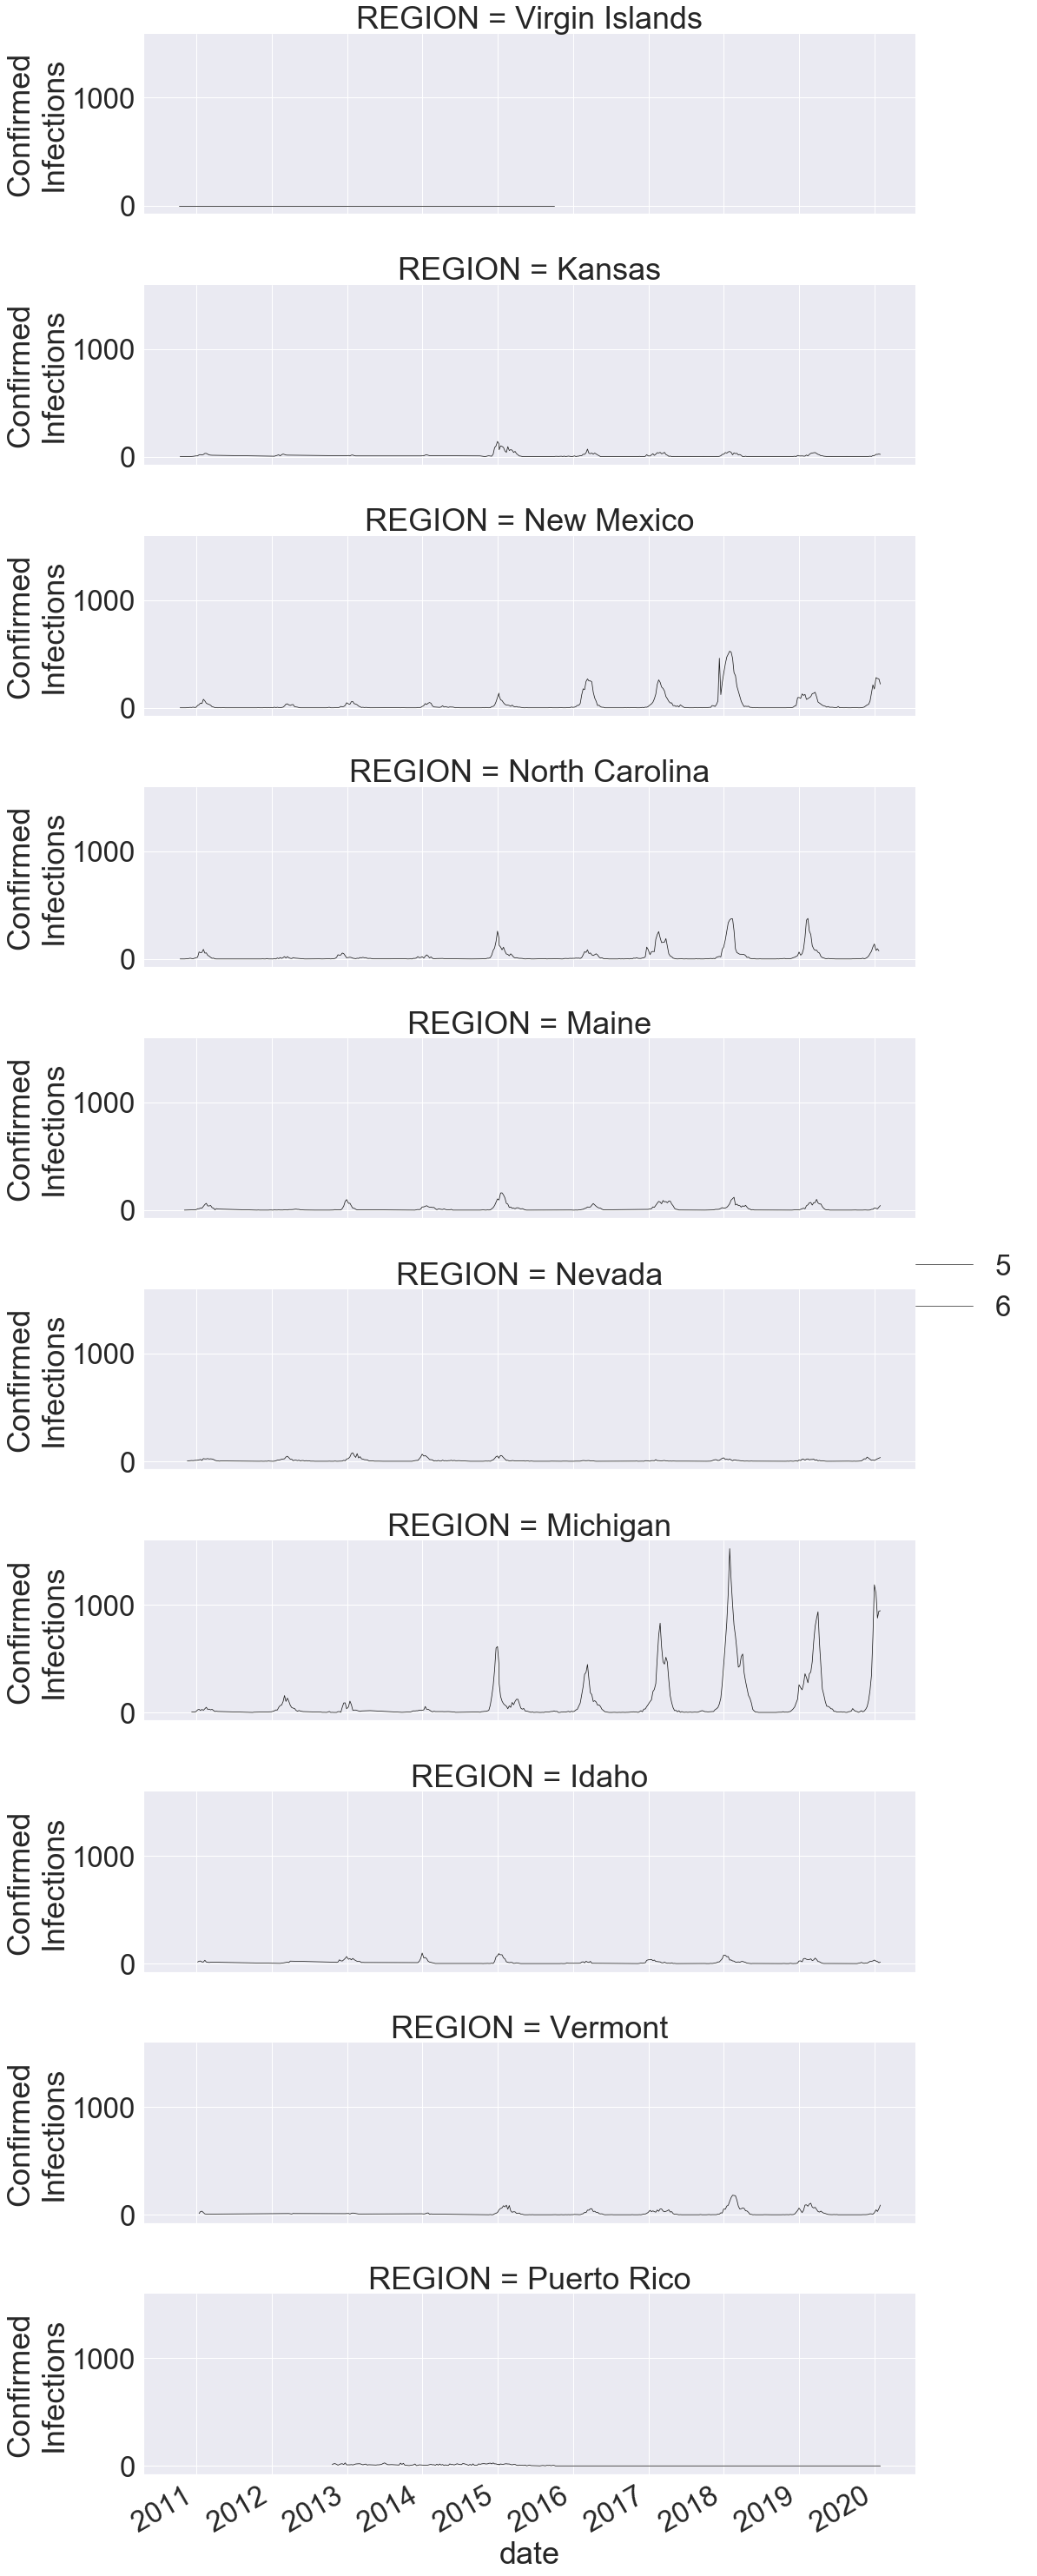

In [589]:
# state_df= [ten_year_influenza_confirmed[masked] for masked in mask_list]
# influenza_deadly_states = pd.concat(state_df)
# import seaborn as sns

# sns.set(font_scale=3)
# g = sns.relplot(x="date", y="Confirmed_Infections",  kind="line", data=influenza_deadly_states, size=6, aspect=3,
#                 color ="k", row = "REGION") 
# g.set_ylabels("Confirmed\nInfections") 
# #plt.ylabel("Confirmed\nInfections")              
# g.fig.autofmt_xdate()

# plt.plot()


# #.figsize(15,8)

In [590]:
 
total_infections = total_infections.set_index(pd.DatetimeIndex(total_infections.date))

In [591]:
total_infections.index[0]

Timestamp('2010-10-08 00:00:00')

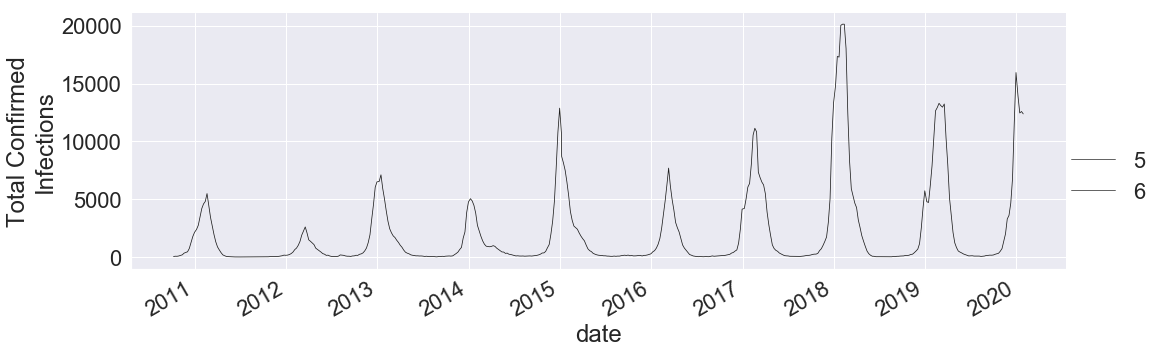

In [592]:
sns.set(font_scale=2)
g = sns.relplot(x="date", y="Confirmed_Infections",  kind="line", data=total_infections , size=6, aspect=3,
                color ="k") 
g.set_ylabels("Total Confirmed\nInfections") 
#plt.ylabel("Confirmed\nInfections")              
g.fig.autofmt_xdate()

plt.plot()
plt.savefig("total US infections", bbox_inches = "tight") 

In [593]:
#test Train split starting a year prior to the start of the 2019/2020 season

split_point = len(total_infections['Confirmed_Infections']) - 68
train_dataset, test_dataset = total_infections['Confirmed_Infections'][0:split_point], total_infections['Confirmed_Infections'][split_point:]

train_dataset.to_csv("CDC_training_data.csv")
test_dataset.to_csv("test_CDC_data.csv")
test_dataset.index[0]

Timestamp('2018-10-15 00:00:00')

# Basic model: mean number of infections

In [646]:
basic_model = train_dataset.mean()
basic_model
basic_model_series = pd.Series(basic_model).repeat(len(predict))


basic_model_series.head()

0    1717.464115
0    1717.464115
0    1717.464115
0    1717.464115
0    1717.464115
dtype: float64

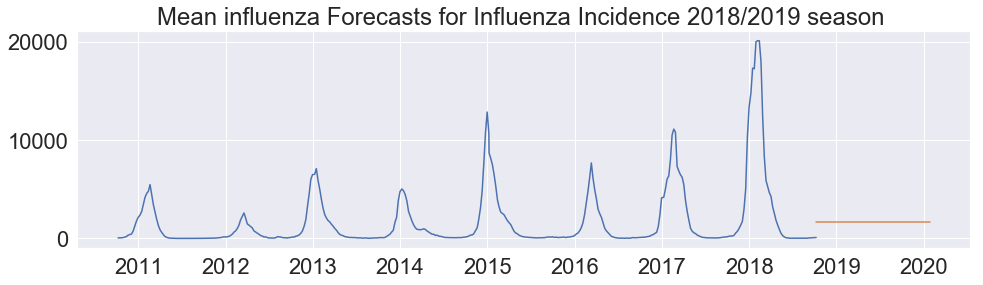

In [651]:
fig, ax = plt.subplots(1, figsize=(16, 4))

ax.plot(train_dataset.index, train_dataset)
ax.plot(predict.index, basic_model_series)
#ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='k', alpha=0.1)
ax.set_title("Mean influenza model prediction for Influenza Incidence 2018/2019 season ");

# Slightly more complicated: mean

 Augmented Dickey-Fuller test for stationarity with:

𝐻0 : The series is not-stationary (specifically, has a unit root).
𝐻a : The series is stationary.

In [594]:
test = sm.tsa.stattools.adfuller(train_dataset)
print("ADF p-value for python series: {0:2.2f}".format(test[1]))

ADF p-value for python series: 0.00


sufficient to reject the null hypothesis. evidence exists that it is stationary


In [595]:
test = sm.tsa.stattools.adfuller(train_dataset.diff()[52:])
print("ADF p-value for differenced python series: {0:2.2f}".format(test[1]))

ADF p-value for differenced python series: 0.00


In [596]:
def plot_series_and_difference(axs, series, title):
    diff = series.diff(periods =52)
    axs[0].plot(series.index.date, series)
    axs[0].set_title("Raw Series: {}".format(title))
    axs[1].plot(series.index.date, diff)
    axs[1].set_title("Series of First Differences: {}".format(title))

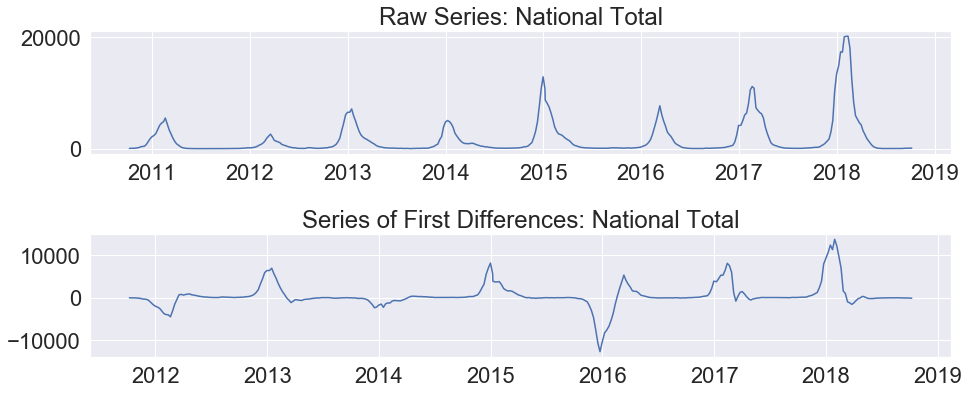

In [605]:
fig, axs = plt.subplots(2, figsize=(14, 6))
plot_series_and_difference(axs, train_dataset, 'National Total')
fig.tight_layout()

diferencing helped

In [598]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_acf_pacf(your_data, lags):
    fig = plt.figure(figsize=(14,8))
    ax1 = fig.add_subplot(211)
    fig = plot_acf(your_data, lags=lags, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = plot_pacf(your_data, lags=lags, ax=ax2, method='ywm')
    plt.show()

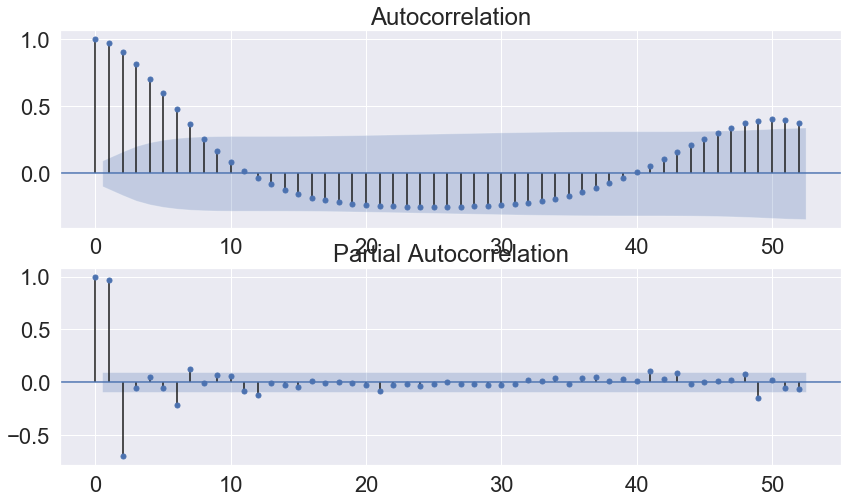

In [599]:
plot_acf_pacf(train_dataset,52)

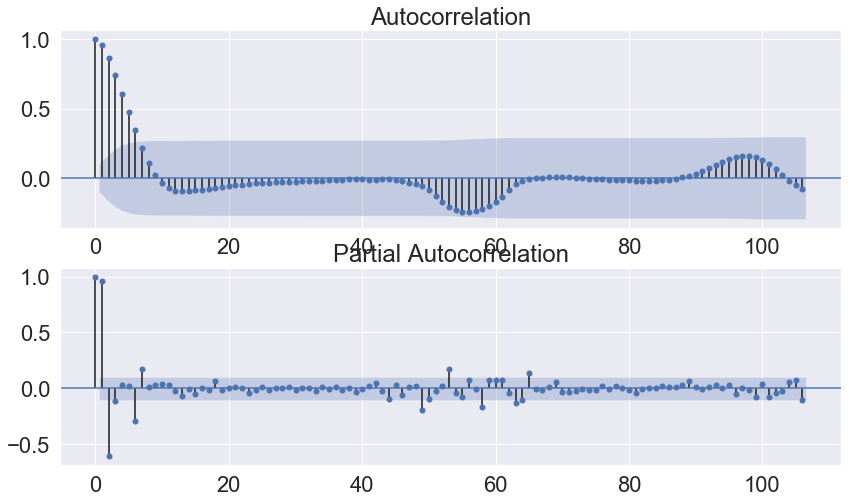

In [604]:

train_differenced_dataset = train_dataset.diff(periods =52).dropna()

plot_acf_pacf(train_differenced_dataset,53*2)



In [775]:
national_ARIMA_model_407 = ARIMA(train_differenced_dataset,order=(4,0,6)).fit()
national_ARIMA_model_307 = ARIMA(train_differenced_dataset,order=(3,0,6)).fit()

In [776]:
#Which model has a lower AIC
print("national_ARIMA_model_407 - national_ARIMA_model_307 = ",national_ARIMA_model_407.aic - national_ARIMA_model_307.aic)


national_ARIMA_model_407 - national_ARIMA_model_307 =  -0.26033575606925297


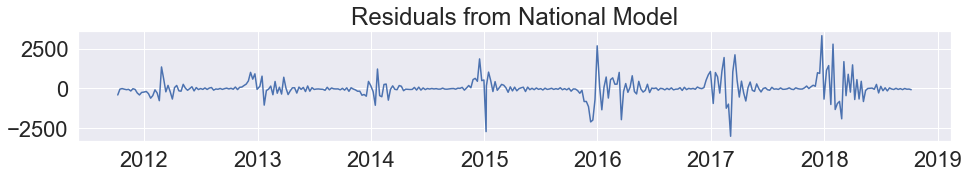

In [608]:
fig, ax = plt.subplots(1, figsize=(14, 3))
ax.plot(national_ARIMA_model_407.resid.index, national_ARIMA_model.resid)
ax.set_title("Residuals from National Model")
plt.tight_layout()

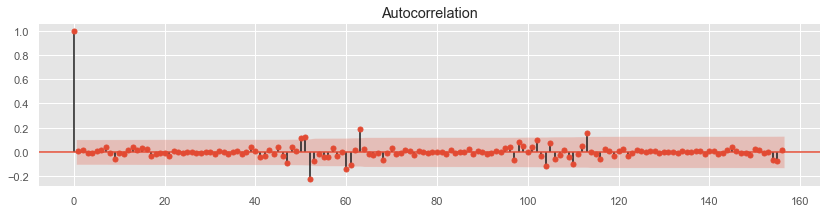

In [425]:
fig, ax = plt.subplots(1, figsize=(14, 3))
_ = sm.graphics.tsa.plot_acf(national_ARIMA_model.resid, lags=3*52, ax=ax)

In [426]:
print(national_ARIMA_model_407.summary())

                               ARMA Model Results                               
Dep. Variable:     Confirmed_Infections   No. Observations:                  366
Model:                       ARMA(4, 7)   Log Likelihood               -2856.147
Method:                         css-mle   S.D. of innovations            589.270
Date:                  Wed, 05 Feb 2020   AIC                           5738.294
Time:                          12:52:30   BIC                           5789.028
Sample:                               0   HQIC                          5758.454
                                                                                
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                        388.5624    397.466      0.978      0.328    -390.456    1167.581
ar.L1.Confirmed_Infections     0.0828      0.234      0.354      0.

In [625]:
predict = national_ARIMA_model_407.predict(start = 470-104, end=486-52)

In [626]:
predict.index = pd.date_range(start='2018-10-01', end='2020-01-29', freq='W')


In [631]:
predicted_inverse_difference = inverse_difference(train_differenced_dataset, predict,52)

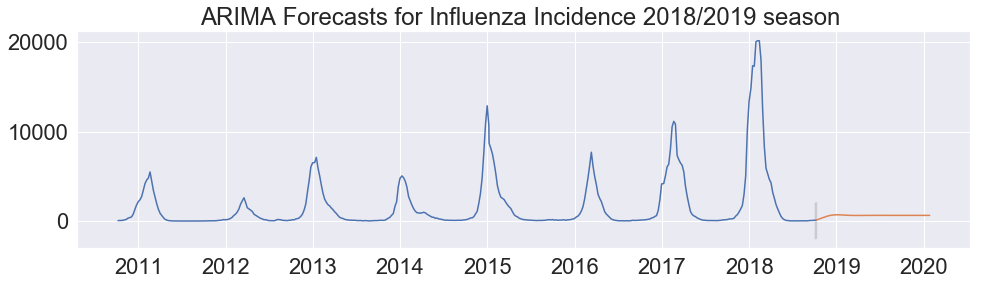

In [649]:
fig, ax = plt.subplots(1, figsize=(16, 4))

ax.plot(train_dataset.index, train_dataset)
ax.plot(predict.index, predicted_inverse_difference)
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='k', alpha=0.1)
ax.set_title("ARIMA Forecasts for Influenza Incidence 2018/2019 season ");

In [ ]:
parameters = [
    {'AR': 4, 'MA': 6},
    {'AR': 3, 'MA': 6},
    {'AR': 4, 'MA': 7},
    {'AR': 3, 'MA': 7},
    {'AR': 2, 'MA': 6},
    {'AR': 2, 'MA': 6}
]

models = {}
for params in parameters:
    models[(params['AR'], params['MA'])] = ARIMA(train_differenced_dataset , 
                                                 order=(params['AR'],
                                                        1, 
                                                        params['MA'])).fit()
    
for model_params in models:
    print("ARIMA({}, 1, {}) AIC: {}".format(model_params[0], 
                                            model_params[1], 
                                            models[model_params].aic))

In [429]:
from math import sqrt
def rms(y_test, y_predict):
    return (sqrt(mean_squared_error(test_dataset, predict[0:68])))


In [636]:
print (" The root means square error is :",rms(test_dataset, predicted_inverse_difference[0:68]))

 The root means square error is : 6054.669335473285


In [431]:
def mean_absolute_percentage_error(y_true, y_pred): 
    #y_true, y_pred = utils.check_arrays(y_true, y_pred)

    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [432]:
mean_absolute_percentage_error(test_dataset, predict[0:68])

nan

In [ ]:
national_model = SARIMAX(train_dataset,
                         order=(4,0,7)
                         ,seasonal_order=(4,1,7,52)).fit()


os.system('afplay /System/Library/Sounds/Blow.aiff')
#SARIMAX(your_ts, order=(0,1,0), seasonal_order=(1,1,0,7)).fit()

In [434]:
print(national_model.summary())

                                                 SARIMAX Results                                                 
Dep. Variable:                                      Confirmed_Infections   No. Observations:                  418
Model:             SARIMAX(0, 1, 0)x(6, 1, [1, 2, 3, 4, 5, 6, 7, 8], 12)   Log Likelihood               -3295.437
Date:                                                   Wed, 05 Feb 2020   AIC                           6620.875
Time:                                                           12:54:24   BIC                           6680.933
Sample:                                                                0   HQIC                          6644.647
                                                                   - 418                                         
Covariance Type:                                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------

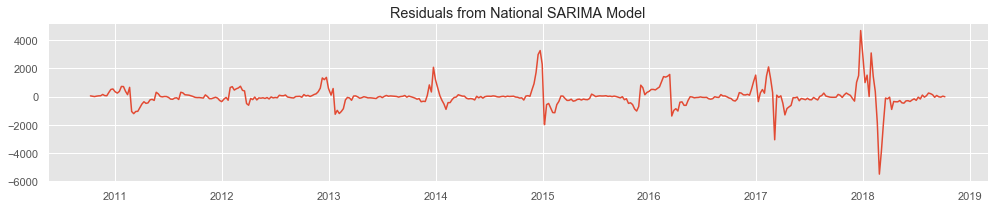

In [435]:
fig, ax = plt.subplots(1, figsize=(14, 3))
ax.plot(national_model.resid.index, national_model.resid)
ax.set_title("Residuals from National SARIMA Model")
plt.tight_layout()

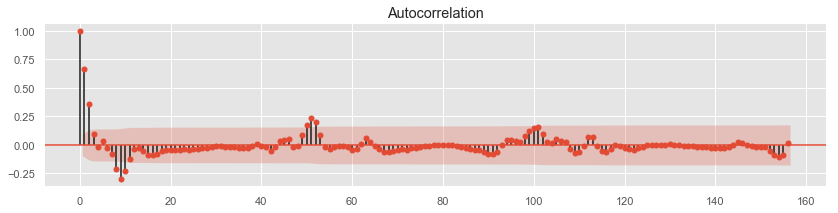

In [436]:
fig, ax = plt.subplots(1, figsize=(14, 3))
_ = sm.graphics.tsa.plot_acf(national_model.resid, lags=3*52, ax=ax)

In [558]:
train_dataset.head()


date
2010-10-08     45.0
2010-10-15     67.0
2010-10-22     62.0
2010-10-29     88.0
2010-11-05    134.0
Name: Confirmed_Infections, dtype: float64

In [559]:
train_dataset.tail()

date
2018-09-10    60.0
2018-09-17    62.0
2018-09-24    80.0
2018-10-01    87.0
2018-10-08    94.0
Name: Confirmed_Infections, dtype: float64

In [560]:
temp = pd.date_range(start = '2010-10-08', end='2018-10-08', freq='W')

DatetimeIndex(['2010-10-10', '2010-10-17', '2010-10-24', '2010-10-31',
               '2010-11-07', '2010-11-14', '2010-11-21', '2010-11-28',
               '2010-12-05', '2010-12-12',
               ...
               '2018-08-05', '2018-08-12', '2018-08-19', '2018-08-26',
               '2018-09-02', '2018-09-09', '2018-09-16', '2018-09-23',
               '2018-09-30', '2018-10-07'],
              dtype='datetime64[ns]', length=418, freq='W-SUN')

In [563]:
train_dataset.index = pd.date_range(start='2010-10-08',
                                    end='2018-10-08', freq='W')

In [565]:
train_dataset.head()

2010-10-10     45.0
2010-10-17     67.0
2010-10-24     62.0
2010-10-31     88.0
2010-11-07    134.0
Freq: W-SUN, Name: Confirmed_Infections, dtype: float64

In [577]:
train_dataset = train_dataset.reindex(pd.date_range(
       start='2010-10-10', end='2021', freq='W'))

In [578]:
train_dataset.head()

2010-10-10     45.0
2010-10-17     67.0
2010-10-24     62.0
2010-10-31     88.0
2010-11-07    134.0
Freq: W-SUN, Name: Confirmed_Infections, dtype: float64

In [570]:
train_dataset.tail()

2020-11-29   NaN
2020-12-06   NaN
2020-12-13   NaN
2020-12-20   NaN
2020-12-27   NaN
Freq: W-SUN, Name: Confirmed_Infections, dtype: float64

In [566]:
train_dataset.tail()

2018-09-09    60.0
2018-09-16    62.0
2018-09-23    80.0
2018-09-30    87.0
2018-10-07    94.0
Freq: W-SUN, Name: Confirmed_Infections, dtype: float64

In [575]:
predict_sarima = national_model.get_prediction(
                   dynamic=True, ax=ax, plot_insample=False)

In [576]:
ci = results.conf_int()
print(ci)

            lower Confirmed_Infections  upper Confirmed_Infections
date                                                              
2018-10-01                -1939.647156                 2062.393547
2018-10-08                -1888.277662                 2113.763042


In [495]:
preds = predict_sarima.predicted_mean
ci = results.conf_int()

fig, ax = plt.subplots(1, figsize=(16, 4))

ax.plot(train_dataset.index, train_dataset)

ax.plot(preds.index, preds)
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='k', alpha=0.1)
ax.set_title("Forecasts for Baseball Search Popularity");

#mean absolute percentage error... look into accuracy metric for ts.

KeyError: 'The `end` argument could not be matched to a location related to the index of the data.'

In [556]:
predict_sarima = national_model.get_prediction(start = '2018-10-01', end=  '2018-10-22',
                   dynamic=True, ax=ax, plot_insample=False)

KeyError: 'The `end` argument could not be matched to a location related to the index of the data.'

In [554]:
preds = predict_sarima.predicted_mean
ci = results.conf_int()
preds

date
2018-10-01    61.373196
2018-10-08    87.115885
dtype: float64

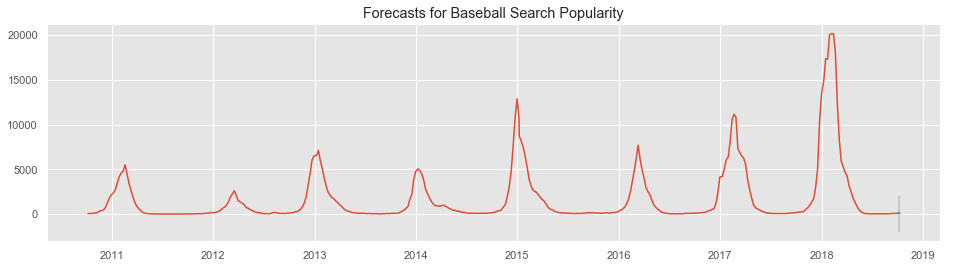

In [555]:
fig, ax = plt.subplots(1, figsize=(16, 4))

ax.plot(train_dataset.index, train_dataset)

ax.plot(preds.index, preds)
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='k', alpha=0.1)
ax.set_title("Forecasts for Baseball Search Popularity");

In [506]:
train_dataset.reindex()

date
2010-10-08      45.0
2010-10-15      67.0
2010-10-22      62.0
2010-10-29      88.0
2010-11-05     134.0
2010-11-12     186.0
2010-11-19     331.0
2010-11-26     395.0
2010-12-03     448.0
2010-12-10     735.0
2010-12-17    1235.0
2010-12-24    1766.0
2010-12-31    2131.0
2011-01-08    2384.0
2011-01-15    2739.0
2011-01-22    3463.0
2011-01-29    4191.0
2011-02-05    4590.0
2011-02-12    4805.0
2011-02-19    5489.0
2011-02-26    4464.0
2011-03-05    3424.0
2011-03-12    2662.0
2011-03-19    1930.0
2011-03-26    1311.0
2011-04-02     870.0
2011-04-09     614.0
2011-04-16     379.0
2011-04-23     188.0
2011-04-30     111.0
               ...  
2018-03-19    5275.0
2018-03-26    4661.0
2018-04-02    4276.0
2018-04-09    3204.0
2018-04-16    2549.0
2018-04-23    1842.0
2018-04-30    1361.0
2018-05-07     916.0
2018-05-14     512.0
2018-05-21     282.0
2018-05-28     151.0
2018-06-04      66.0
2018-06-11      61.0
2018-06-18      24.0
2018-06-25      21.0
2018-07-02      26.0
2018-07-

In [ ]:
fig, ax = plt.subplots(1, figsize=(14, 4))
ax.plot(electric_series['2010':].index, electric_series['2010':])
fig = electric_model.plot_predict('2011-11-30', '2013', 
                                  dynamic=True, ax=ax, plot_insample=False)

ax.legend().get_texts()[1].set_text("95% Prediction Interval")
ax.legend(loc="lower left")

ax.set_title("Electric Series Forecasts from ARIMA Model");

In [462]:
#model_1 = SARIMAX(total_infections['Confirmed_Infections'], order=(0,1,0), seasonal_order=(1,1,0,7)).fit()
#model_2 = SARIMAX(ts, order=(3,1,0), seasonal_order=(1,1,0,7)).fit()

In [548]:
test_dataset.index[52]
train_dataset.index[-2]


Timestamp('2018-10-01 00:00:00')

In [613]:
x = np.array([1, 2, 4, 7, 0])
x_diff = np.diff(x)
x_diff

array([ 1,  2,  3, -7])

In [617]:
np.r_[x[0], x_diff]

array([ 1,  1,  2,  3, -7])

In [618]:
np.r_[x[0], x_diff].cumsum()

array([1, 2, 4, 7, 0])

In [624]:
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [627]:
predict.head()

2018-10-07   -120.820593
2018-10-14    -89.726293
2018-10-21    -10.533679
2018-10-28     51.175625
2018-11-04    123.902005
Freq: W-SUN, dtype: float64

In [628]:
np.r_[]

69

In [654]:
predicted_inverse_difference = inverse_difference(train_dataset, predict,52)

In [653]:
predicted_inverse_difference

2018-10-07    111.179407
2018-10-14    142.273707
2018-10-21    221.466321
2018-10-28    283.175625
2018-11-04    355.902005
2018-11-11    414.218776
2018-11-18    486.338814
2018-11-25    541.389212
2018-12-02    592.354670
2018-12-09    631.531410
2018-12-16    657.129235
2018-12-23    676.955082
2018-12-30    682.459367
2019-01-06    685.889603
2019-01-13    679.689728
2019-01-20    672.837829
2019-01-27    662.380673
2019-02-03    651.619295
2019-02-10    641.762872
2019-02-17    631.844456
2019-02-24    624.851954
2019-03-03    618.224489
2019-03-10    614.501503
2019-03-17    611.577711
2019-03-24    610.517769
2019-03-31    610.442292
2019-04-07    611.080169
2019-04-14    612.552101
2019-04-21    613.962445
2019-04-28    615.830089
                 ...    
2019-07-07    621.818415
2019-07-14    621.575527
2019-07-21    621.305020
2019-07-28    621.042917
2019-08-04    620.827277
2019-08-11    620.627298
2019-08-18    620.496786
2019-08-25    620.387247
2019-09-01    620.335118


In [705]:
def plot_trend_data(ax, name, series):
    ax.plot(series.index.date, series)
    ax.set_title("Seasonal Trend {}".format(name))

In [706]:
def create_monthly_dummies(series):
    month = series.index.month
    # Only take 11 of the 12 dummies to avoid strict colinearity.
    return pd.get_dummies(month).iloc[:, :11]

In [707]:
def create_weekly_dummies(series):
    week = series.index.week
    # Only take 51 of the 52 dummies to avoid strict colinearity.
    return pd.get_dummies(week).iloc[:, :51]

In [708]:
def fit_seasonal_trend(series):
    dummies = create_monthly_dummies(series)
    X = sm.add_constant(dummies.values, prepend=False)
    seasonal_model = sm.OLS(series.values, X).fit()
    return seasonal_model.predict(X)

In [709]:
def fit_weekly_seasonal_trend(series):
    dummies = create_weekly_dummies(series)
    X = sm.add_constant(dummies.values, prepend=False)
    seasonal_model = sm.OLS(series.values, X).fit()
    return seasonal_model.predict(X)

In [710]:
def plot_seasonal_trend(ax, name, series):
    seasons_average_trend = fit_seasonal_trend(series)
    plot_trend_data(ax, name, series, )
    ax.plot(series.index.date, seasons_average_trend, '-')

In [711]:
def plot_weekly_seasonal_trend(ax, name, series):
    seasons_average_trend = fit_weekly_seasonal_trend(series)
    plot_trend_data(ax, name, series, )
    ax.plot(series.index.date, seasons_average_trend, '-')

In [763]:
#fit the sesonla trend for by month
fst = fit_seasonal_trend(train_dataset)[0:48]


monthly_avg =[fst[i] for i in range(0,len(fst),4)]
months = ["oct","nov","dec","jan","feb","mar", "apr","may", "jun","jul", "aug", "sept"]
month_avg_dict=dict( zip(months,monthly_avg))
month_avg_dict

{'oct': 137.35897435898278,
 'nov': 476.1562500000018,
 'dec': 3121.05,
 'jan': 3121.05,
 'feb': 5827.242424242425,
 'mar': 5682.093750000002,
 'apr': 3535.0,
 'may': 1560.099999999995,
 'jun': 390.3750000000009,
 'jul': 121.03125000000182,
 'aug': 49.64999999999782,
 'sept': 56.25000000000091}

In [712]:
influenza_seasonal_trend = fit_seasonal_trend(train_dataset)

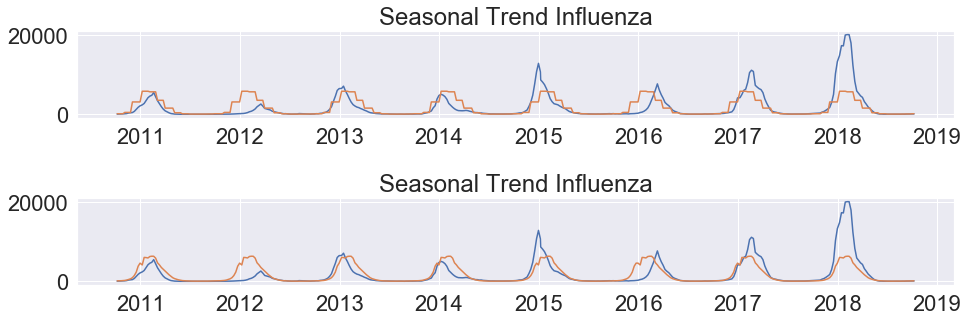

In [713]:
fig, axs = plt.subplots(2, figsize=(14, 5))

plot_seasonal_trend(axs[0], 'Influenza', train_dataset)
plot_weekly_seasonal_trend(axs[1], "Influenza", train_dataset)

plt.tight_layout()

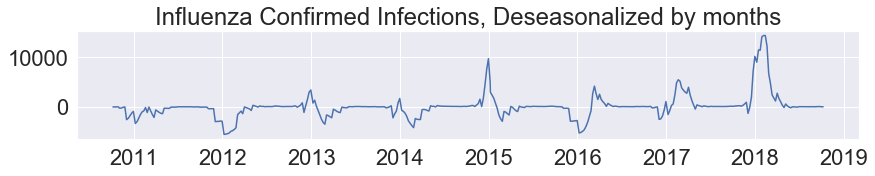

In [716]:
influenza_seasonal_trend = fit_seasonal_trend(train_dataset)
influenza_seasonal_detrended = train_dataset - influenza_seasonal_trend

fig, ax = plt.subplots(figsize=(14, 2))
ax.plot(train_dataset.index, influenza_seasonal_detrended)
ax.set_title("Influenza Confirmed Infections, Deseasonalized by months");

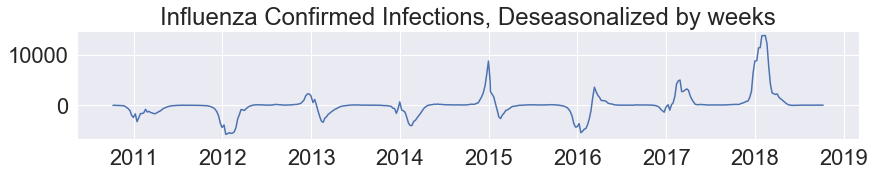

In [717]:
influenza_seasonal_trend = fit_weekly_seasonal_trend(train_dataset)
influenza_seasonal_detrended = train_dataset - influenza_seasonal_trend

fig, ax = plt.subplots(figsize=(14, 2))
ax.plot(train_dataset.index, influenza_seasonal_detrended)
ax.set_title("Influenza Confirmed Infections, Deseasonalized by weeks");

In [725]:
type(train_dataset)

pandas.core.series.Series

In [726]:
influenza_decomposition = sm.tsa.seasonal_decompose(train_dataset, period =52)

In [727]:
def plot_shared_yscales(axs, x, ys, titles):
    ymiddles =  [ (y.max()+y.min())/2 for y in ys ]
    yrange = max( (y.max()-y.min())/2 for y in ys )
    for ax, y, title, ymiddle in zip(axs, ys, titles, ymiddles):
        ax.plot(x, y)
        ax.set_title(title)
        ax.set_ylim((ymiddle-yrange, ymiddle+yrange))

In [728]:
def plot_seasonal_decomposition(axs, series, sd):
    plot_shared_yscales(axs,
                        series.index,
                        [series, sd.trend, sd.seasonal, sd.resid],
                        ["Raw Series", 
                         "Trend Component $T_t$", 
                         "Seasonal Component $S_t$",
                         "Residual Component $R_t$"])

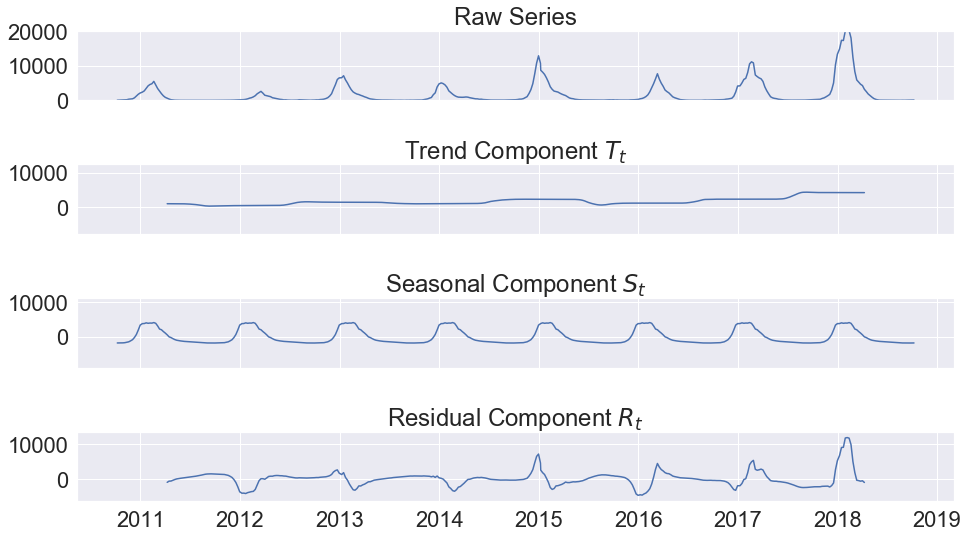

In [730]:
fig, axs = plt.subplots(4, figsize=(14, 8), sharex=True)
plot_seasonal_decomposition(axs, 
                            train_dataset, 
                            influenza_decomposition)
plt.tight_layout()